In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K

import tensorflow as tf

from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
2024-05-11 10:22:40.532468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 10:22:40.532577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 10:22:40.707099: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [63]:
# !pip install pydotplus
# !pip install graphviz
!conda uninstall pyplot
!conda uninstall pyplotplus
!conda uninstall graphviz

WARNING conda.models.version:get_matcher(556): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.7.1.*, but conda is ignoring the .* and treating it as 1.7.1
WARNING conda.models.version:get_matcher(556): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
WARNING conda.models.version:get_matcher(556): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
done
Solving environment: failed

PackagesNotFoundError: The following packages are missing from the target environment:
  - pyplot


WARNING conda.models.version:get_matcher(556): Using .* with relational operator is superfluous and deprecated and will be removed in a future version o

In [2]:
df0 = pd.read_csv('/kaggle/input/bitcoin-tweets/Bitcoin_tweets.csv',chunksize=100000,lineterminator='\n')
df = pd.concat(df0)

/tmp/ipykernel_34/435183171.py:2: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df0)
/tmp/ipykernel_34/435183171.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df0)
/tmp/ipykernel_34/435183171.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df0)
/tmp/ipykernel_34/435183171.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df0)
/tmp/ipykernel_34/435183171.py:2: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df0)
/tmp/ipykernel_34/435183171.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df0)
/tmp/ipykernel_34/435183171.py:2: DtypeWarning: C

In [3]:
df=df[['text']][0:20000]
df

,text
0,Blue Ridge Bank shares halted by NYSE after #b...
1,"😎 Today, that's this #Thursday, we will do a ""..."
2,"Guys evening, I have read this article about B..."
3,$BTC A big chance in a billion! Price: \487264...
4,This network is secured by 9 508 nodes as of t...
...,...
19995,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...
19996,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...
19997,LINK IN MY BIO!!! \nFlex is dropping officiall...
19998,#Bitcoin #Btc\n\nWait and see.... https://t.co...


In [4]:
def tweet2words(tweet):
    ''' 
    Convert tweet text into a sequence of words 
    :tweet -> text data
    '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words


In [6]:
cleantext=[]
for item in tqdm(df['text']):
    words=tweet2words(item)
    cleantext+=[words]
df['cleantext']=cleantext
df

100%|██████████| 20000/20000 [01:02<00:00, 318.88it/s]


,text,cleantext
0,Blue Ridge Bank shares halted by NYSE after #b...,"[blue, ridg, bank, share, halt, nyse, bitcoin,..."
1,"😎 Today, that's this #Thursday, we will do a ""...","[today, thursday, take, 2, friend, leowandersl..."
2,"Guys evening, I have read this article about B...","[guy, even, read, articl, btc, would, like, sh..."
3,$BTC A big chance in a billion! Price: \487264...,"[btc, big, chanc, billion, price, 4872644, 0, ..."
4,This network is secured by 9 508 nodes as of t...,"[network, secur, 9, 508, node, today, soon, bi..."
...,...,...
19995,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...,"[btc, sell, pressur, alert, price, trade, arou..."
19996,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...,"[husseinchindo, kayodebakre8, wrong, bitcoin, ..."
19997,LINK IN MY BIO!!! \nFlex is dropping officiall...,"[link, bio, flex, drop, offici, tomorrow, feb,..."
19998,#Bitcoin #Btc\n\nWait and see.... https://t.co...,"[bitcoin, btc, wait, see, http, co, vdaseguhlp]"


In [7]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [8]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [9]:
df2 = compute_vader_scores(df,'cleantext')
df2

,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,Blue Ridge Bank shares halted by NYSE after #b...,"[blue, ridg, bank, share, halt, nyse, bitcoin,...",0.000,0.872,0.128,0.2960,blue ridg bank share halt nyse bitcoin atm ann...
1,"😎 Today, that's this #Thursday, we will do a ""...","[today, thursday, take, 2, friend, leowandersl...",0.000,0.775,0.225,0.4939,today thursday take 2 friend leowandersleb btc...
2,"Guys evening, I have read this article about B...","[guy, even, read, articl, btc, would, like, sh...",0.000,0.719,0.281,0.5719,guy even read articl btc would like share http...
3,$BTC A big chance in a billion! Price: \487264...,"[btc, big, chanc, billion, price, 4872644, 0, ...",0.000,1.000,0.000,0.0000,btc big chanc billion price 4872644 0 2021 02 ...
4,This network is secured by 9 508 nodes as of t...,"[network, secur, 9, 508, node, today, soon, bi...",0.200,0.800,0.000,-0.5423,network secur 9 508 node today soon biggest be...
...,...,...,...,...,...,...,...
19995,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...,"[btc, sell, pressur, alert, price, trade, arou...",0.000,0.855,0.145,0.2960,btc sell pressur alert price trade around 3782...
19996,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...,"[husseinchindo, kayodebakre8, wrong, bitcoin, ...",0.165,0.638,0.197,-0.1027,husseinchindo kayodebakre8 wrong bitcoin legal...
19997,LINK IN MY BIO!!! \nFlex is dropping officiall...,"[link, bio, flex, drop, offici, tomorrow, feb,...",0.130,0.870,0.000,-0.2732,link bio flex drop offici tomorrow feb 06 2021...
19998,#Bitcoin #Btc\n\nWait and see.... https://t.co...,"[bitcoin, btc, wait, see, http, co, vdaseguhlp]",0.000,1.000,0.000,0.0000,bitcoin btc wait see http co vdaseguhlp


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

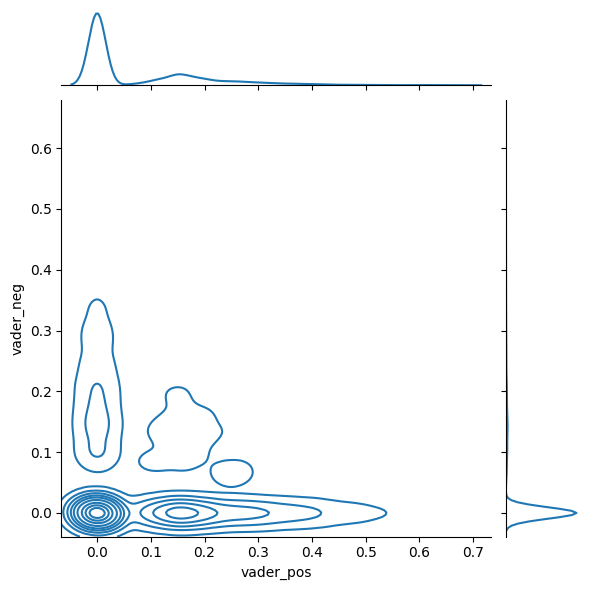

In [10]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neg', kind="kde")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

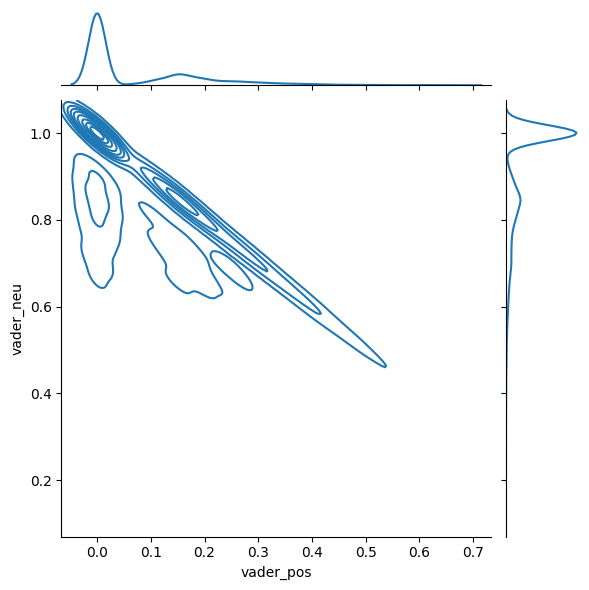

In [11]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neu', kind="kde")

In [12]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_neg']>0:
        class0+=[0]
    elif df2.loc[i,'vader_pos']>0:
        class0+=[2]        
    else:
        class0+=[1]  

In [13]:
df['class']=class0
df['class'].value_counts()

class
1    11246
2     6079
0     2675
Name: count, dtype: int64

In [14]:
max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 blue ridg bank share halt nyse bitcoin atm announc http co xaazmajkiv myblueridgebank http co sgbxmkp1si 
After Tokenization & Padding 
 [1399 1804  254  406 3652 2760    3 1149  259    2    1    2    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [15]:
print(X.shape)

(20000, 50)


In [16]:
y = pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (12000, 50) (12000, 3)
Validation Set:  (4000, 50) (4000, 3)
Test Set:  (4000, 50) (4000, 3)


In [17]:
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [33]:
import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# The Model Part.

In [37]:
from tensorflow.keras.optimizers import SGD



sgd = SGD(0.1, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [66]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, show_shapes=True)

In [64]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [65]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5585 - loss: 0.9648 - precision: 0.5591 - recall: 0.4785 - val_accuracy: 0.5663 - val_loss: 0.9466 - val_precision: 0.5663 - val_recall: 0.5663
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5706 - loss: 0.9178 - precision: 0.6107 - recall: 0.4765 - val_accuracy: 0.6970 - val_loss: 0.7475 - val_precision: 0.7815 - val_recall: 0.5760
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7447 - loss: 0.6369 - precision: 0.7894 - recall: 0.6805 - val_accuracy: 0.8440 - val_loss: 0.3930 - val_precision: 0.8559 - val_recall: 0.8378
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8550 - loss: 0.3584 - precision: 0.8708 - recall: 0.8427 - val_accuracy: 0.8832 - val_loss: 0.3618 - val_precision: 0.8921 - val_recall: 0.8660
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8898 - loss: 0.2841 - precision: 0.8967 - recall: 0.8822 - val_accuracy: 0.9025 - val_loss: 0

In [67]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9705
Precision : 0.9712
Recall    : 0.9703
F1 Score  : 0.9707


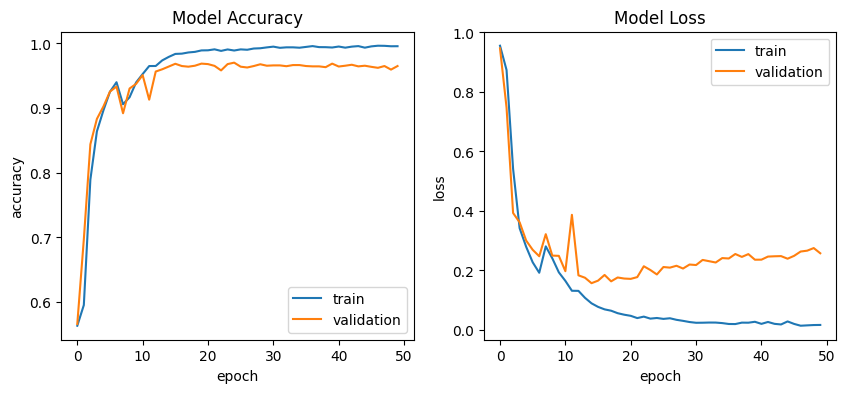

In [68]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1    2203
2    1251
0     546
Name: count, dtype: int64
1    2227
2    1261
0     512
Name: count, dtype: int64


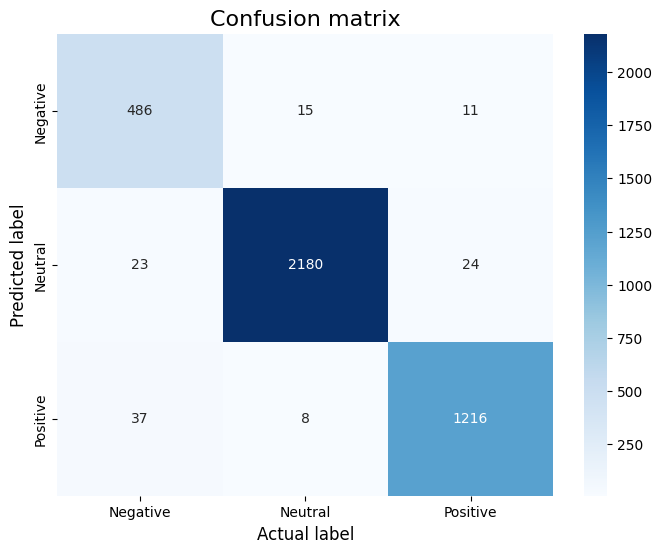

In [69]:
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)